.. meta::
   :description: Using the responsible AI toolbox to build workflows.

> Copyright (c) 2022 Massachusetts Institute of Technology  
> SPDX-License-Identifier: MIT 



# Building a Workflows for Cross Validation and Adversarial Robustness
This notebook demonstrates how the to build [workflows]() for scalable experimentation.  Two basic workflows will be demonstrated:

- Cross-Validation Workflow: Demonstrates how to build scalable cross validation training workflow.
- Robustness Curve Workflow: Demonstrates how to build scalable robustness testing for each of the models trained in the "Cross-Validation Workflow"

If you haven't already, follow the steps at the beginning of the previous tutorial to install the rAI-toolbox and create a Jupyter notebook called `ImageNet-Concept-Probing.ipynb`. You can then follow along with this tutorial by copying, pasting, and running the code blocks below in the cells of your notebook.

## Imports

In [1]:
from collections import defaultdict
from pathlib import Path
from typing import Callable, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import torch as tr
from tqdm.auto import tqdm


In [2]:
# Hydra and hydra-zen
from hydra.core.config_store import ConfigStore
from hydra_zen import MISSING, builds, instantiate, load_from_yaml, make_config

# sklearn and torch
from sklearn.model_selection import StratifiedKFold
from torch import Tensor, nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

# rAI-toolbox
from rai_toolbox import evaluating, frozen
from rai_toolbox._typing import Partial
from rai_toolbox.mushin.workflows import (
    MultiRunMetricsWorkflow,
    RobustnessCurve,
    multirun,
)


## Experiment Functions and Classes

In [3]:
class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(32, 32, 3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(32, 32, 3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 10, 3),
            nn.Flatten(1),
        )

    def forward(self, x):
        return self.model(x)

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.model(x)

In [4]:
def split_dataset(dataset: MNIST, n_splits: int, fold: int) -> Tuple[Subset, Subset]:
    """Provide training and validation splits using `sklearn.model_selection.StratifiedKfold`"""

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state = 49)
    train_indices, val_indices = list(kfold.split(range(len(dataset)), dataset.targets))[fold]
    return Subset(dataset, train_indices), Subset(dataset, val_indices)

In [5]:
def train_model(
    fold: int,
    model: nn.Module,
    dataset: MNIST,
    optimizer: Partial[Optimizer],
    perturber: Partial,
    num_epochs: int = 10,
    batch_size: int = 100,
    num_workers: int = 4,
    device: str = "cpu",
    n_splits: int = 5
):
    """Trains a model."""

    train_dataset, val_dataset = split_dataset(dataset, n_splits, fold)
    dl_train = DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True,
    )
    dl_val = DataLoader(
        val_dataset, batch_size=batch_size, num_workers=num_workers
    )
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optim = optimizer(model.parameters())

    epochs = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    for i in tqdm(range(num_epochs)):
        epochs.append(i)
        
        _losses = []
        _pred = []
        for data, target in dl_train:
            data = data.to(device)
            target = target.to(device)

            if perturber:
                data, _ = perturber(model=model, data=data, target=target)

            logit = model(data)
            loss = criterion(logit, target)

            optim.zero_grad()
            loss.backward()
            optim.step()

            with tr.no_grad():
                _losses.append(loss.item())
                _pred.extend((logit.argmax(1) == target).detach().cpu())
    
        with evaluating(model):
            _val_loss = []
            _val_pred = []
            for data, target in dl_val:
                data = data.to(device)
                target = target.to(device)

                if perturber:
                    data, _ = perturber(model=model, data=data, target=target)

                logit = model(data)
                loss = criterion(logit, target)

                _val_loss.append(loss.item())
                _val_pred.extend((logit.argmax(1) == target).cpu())

        train_loss.append(sum(_losses) / len(_losses))
        train_accuracy.append(sum(_pred) / len(_pred))
        val_loss.append(sum(_val_loss) / len(_val_loss))
        val_accuracy.append(sum(_val_pred) / len(_val_pred))

    metrics = dict(epochs=epochs, train_loss=train_loss, train_accuracy=train_accuracy, val_loss=val_loss, val_accuracy=val_accuracy)
    tr.save(metrics, "fit_metrics.pt")
    tr.save(model.state_dict(), "model.ckpt")
    return metrics

In [6]:
@tr.no_grad()
def test_model(
    exp_dir: Union[Path, str],
    dataset: MNIST,
    perturber: Callable[[], Tuple[Tensor, Tensor]],
    batch_size: int = 100,
    num_workers: int = 4,
    device: str = "cpu",
):
    """Tests a model."""

    # load model configuration from experiment directory
    # and instantiate model
    exp_dir = Path(exp_dir)
    exp_cfg = exp_dir / ".hydra/config.yaml"
    assert exp_cfg.exists()
    exp_cfg = load_from_yaml(exp_cfg)
    model = instantiate(exp_cfg.model)

    # get path to model checkpoint in experiment directory
    # and load to model
    ckpt = exp_dir / "model.ckpt"
    assert ckpt.exists()
    state_dict = tr.load(ckpt)
    model.load_state_dict(state_dict)

    model = model.to(device)
    test_dl = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

    preds = []
    with evaluating(model):
        for data, target in test_dl:
            data = data.to(device)
            target = target.to(device)

            if perturber:
                data, _ = perturber(model=model, data=data, target=target)

            logit = model(data)

            # Save if prediction is correct or not for each sample
            preds.extend((logit.argmax(1) == target).float().cpu().numpy())

    acc = sum(preds) / len(preds)
    metrics = dict(accuracy=acc.item())
    tr.save(metrics, "test_metrics.pt")
    return metrics
    

## hydra-zen Configuration

In [7]:
Augmentations = builds(transforms.Compose, [builds(transforms.RandomCrop, size=28, padding=4), builds(transforms.ToTensor)])
TrainDataset = builds(MNIST, root="${data_dir}", train=True, transform=Augmentations)
TestDataset = builds(MNIST, root="${data_dir}", train=False, transform=builds(transforms.ToTensor))
ConvModelCfg = builds(ConvModel)
LinearModelCfg = builds(LinearModel)
Optim = builds(tr.optim.SGD, lr=0.1, zen_partial=True)

from rai_toolbox.optim import L2ProjectedOptim, LinfProjectedOptim
from rai_toolbox.perturbations import gradient_ascent
L2PGD = builds(L2ProjectedOptim, zen_partial=True)
LinfPGD = builds(LinfProjectedOptim, zen_partial=True)

def lr_for_pgd(epsilon, num_steps):
    return 2.5 * epsilon / num_steps

Perturber = builds(
    gradient_ascent,
    optimizer="${optimizer}",
    epsilon="${epsilon}",
    steps="${steps}",
    lr=builds(lr_for_pgd, "${epsilon}", "${steps}"),
    zen_partial=True,
    populate_full_signature=True
)

Trainer = builds(
    train_model,
    fold="${fold}",
    dataset=TrainDataset,
    optimizer=Optim,
    perturber="${perturber}",
    n_splits="${n_splits}",
    device="${device}",
    zen_partial=True,
    populate_full_signature=True,
)

Tester = builds(
    test_model,
    dataset=TestDataset,
    perturber="${perturber}",
    device="${device}",
    populate_full_signature=True,
    zen_partial=True,
)

Config = make_config(
    defaults = [
        "_self_",
        {"model": "linear"},
    ],
    data_dir = "${oc.env:HOME}/.torch/data",
    model=MISSING,
    evalulator=Trainer,
    perturber=None,
    ckpt=None,
    fold=0,
    n_splits=5,
    device="cpu",
    exp_dir=None
)

TestConfig = make_config(
    defaults = [
        "_self_",
        {"optimizer": "l2pgd"},
    ],
    data_dir = "${oc.env:HOME}/.torch/data",
    exp_dir=MISSING,
    evalulator=Tester,
    perturber=Perturber,
    optimizer=MISSING,
    epsilon=0.0,
    steps=10,
    device="cpu",
)

In [8]:
cs = ConfigStore.instance()
cs.store(name="cnn", group="model", node=ConvModelCfg)
cs.store(name="linear", group="model", node=LinearModelCfg)
cs.store(name="l2pgd", group="optimizer", node=L2PGD)
cs.store(name="linfpgd", group="optimizer", node=LinfPGD)

## Cross Validation Workflow

In [9]:
class CrossValWorkFlow(MultiRunMetricsWorkflow):
    @staticmethod
    def evaluation_task(evalulator: Partial[Trainer], model: nn.Module, ckpt):
        if ckpt is not None:
            state_dict = tr.load(ckpt)
            model.load_state_dict(state_dict)
        return evalulator(model=model)

    def run(self, n_splits: int, **run_kwargs):
        fold = multirun(range(n_splits))
        super().run(n_splits=n_splits, fold=fold, **run_kwargs)

In [10]:
# kfold_task = CrossValWorkFlow(Config)
# kfold_task.run(n_splits=2, model=multirun(["linear", "cnn"]), device="cuda:0")
## You can load previous experiments
kfold_task = CrossValWorkFlow().load_from_dir("multirun/2022-05-11/09-28-46", metrics_filename="fit_metrics.pt")

In [11]:
kfold_task.working_dir

PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/multirun/2022-05-11/09-28-46')

In [12]:
xdata = kfold_task.to_xarray(coord_from_metrics="epochs")
xdata

<xarray.Dataset>
Dimensions:         (fold: 2, model: 2, epochs: 10)
Coordinates:
  * fold            (fold) int64 0 1
  * model           (model) <U6 'linear' 'cnn'
  * epochs          (epochs) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    train_loss      (fold, model, epochs) float64 2.207 1.491 ... 0.04176 0.04
    train_accuracy  (fold, model, epochs) float32 0.2117 0.4806 ... 0.9875
    val_loss        (fold, model, epochs) float64 1.873 1.045 ... 0.05298
    val_accuracy    (fold, model, epochs) float32 0.3603 0.6473 ... 0.9837
Attributes:
    n_splits:  2
    device:    cuda\:0

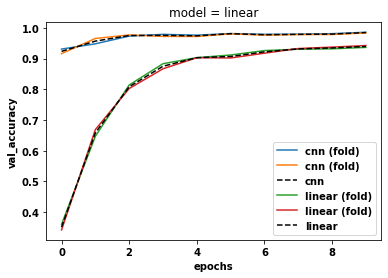

In [13]:
fig, ax = plt.subplots()
for name, g in xdata.groupby("model"):
    g.val_accuracy[:, 0].plot.line(x="epochs", label=f"{name} (fold)", ax=ax)
    g.val_accuracy[:, 0].mean("fold").plot.line(x="epochs", label=name, ax=ax, linestyle="--", color="k")
plt.legend()

## Robustness Curve

In [17]:
class ExperimentRobustnessCurve(RobustnessCurve):
    @staticmethod
    def evaluation_task(evalulator: Partial[Tester], exp_dir: str):
        return evalulator(exp_dir=exp_dir)

    def load_from_dir(self,
        working_dir: Union[Path, str],
        config_dir: str = ".hydra",
        metrics_filename: str = "test_metrics.pt",
    ) -> "ExperimentRobustnessCurve":
        super().load_from_dir(working_dir=working_dir, config_dir=config_dir, metrics_filename=metrics_filename)

        ################################################
        # Load multirun values from experiment directory
        ################################################
        multirun_cfg = self.working_dir / "multirun.yaml"
        assert (
            multirun_cfg.exists()
        ), "Working directory does not contain `multirun.yaml` file.  Be sure to use the value of the Hydra sweep directory for the workflow"

        self._exp_multirun_task_overrides = defaultdict(list)
        overrides = load_from_yaml(multirun_cfg).hydra.overrides.task
        for o in overrides:
            k, v = o.split("=")
            if k == "exp_dir":
                dirs = v.split(",")
                for dir in dirs:
                    overrides = load_from_yaml(
                        Path(dir) / f"{config_dir}/overrides.yaml"
                    )
                    output = self._parse_overrides(overrides)

                    for ko, vo in output.items():
                        self._exp_multirun_task_overrides[ko].append(vo)


                break

        return self

    def to_xarray(self, non_multirun_params_as_singleton_dims: bool = False):
        xdata = super().to_xarray(non_multirun_params_as_singleton_dims=non_multirun_params_as_singleton_dims)

        ##################################
        # Add multirun coordinates to data
        ##################################
        exp_dir = xdata.coords["exp_dir"]
        coords = {}
        for k, v in self._exp_multirun_task_overrides.items():
            if len(v) == len(exp_dir):
                uv = list(set(np.unique(v)))
                if len(uv) > 1 or non_multirun_params_as_singleton_dims:
                    coords[k] = (["exp_dir"], v)

        return xdata.assign_coords(coords)

In [18]:
exp_dir = [m.parent for m in kfold_task.working_dir.absolute().glob("**/model.ckpt")]
exp_dir

[PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/multirun/2022-05-11/09-28-46/0'),
 PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/multirun/2022-05-11/09-28-46/1'),
 PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/multirun/2022-05-11/09-28-46/2'),
 PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/multirun/2022-05-11/09-28-46/3')]

In [19]:
# robustness_curve_task = ExperimentRobustnessCurve(TestConfig)
# robustness_curve_task.run(epsilon=[0,1,2], exp_dir=multirun(exp_dir))

## You can load an old experiment
robustness_curve_task = ExperimentRobustnessCurve().load_from_dir("multirun/2022-05-11/09-44-42")

In [20]:
robustness_curve_task.working_dir

PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/multirun/2022-05-11/09-44-42')

In [21]:
rdata = robustness_curve_task.to_xarray()
rdata

<xarray.Dataset>
Dimensions:   (exp_dir: 4, epsilon: 3)
Coordinates:
  * exp_dir   (exp_dir) <U101 '/home/justin_goodwin/projects/raiden/rai_toolb...
  * epsilon   (epsilon) int64 0 1 2
    fold      (exp_dir) int64 0 0 1 1
    model     (exp_dir) <U6 'linear' 'cnn' 'linear' 'cnn'
Data variables:
    accuracy  (exp_dir, epsilon) float64 0.9537 0.2386 0.0066 ... 0.1001 0.0

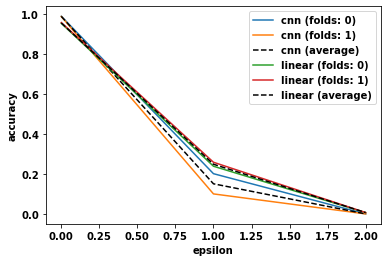

In [22]:
fig, ax = plt.subplots()
for name, g in rdata.groupby("model"):
    for fold, gf in g.groupby("fold"):
        gf.accuracy.plot.line(x="epsilon", label=f"{name} (folds: {fold})", ax=ax)
    g.accuracy.mean("exp_dir").plot.line(x="epsilon", label=f"{name} (average)", ax=ax, linestyle="--", color="k")

plt.legend()